In [9]:
%matplotlib nbagg

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

# Simple problem: Planet with mass $m$ orbiting a star with mass $M\gg m$

![Elliptical orbit](ellipse.png "Elements of the orbit")

# Recasting the problem in one-body terms

Solving the problem requires computing the trajectories of the star ($\mathbf{x}_M\left(t\right)$) and the planet ($\mathbf{x}_m\left(t\right)$). However, it is advantageous to study the following two linear combinations instead:

$\mathbf{X} = \frac{M\mathbf{x}_M + m\mathbf{x}_m}{M+m}$

$\mathbf{x} = \mathbf{x}_m - \mathbf{X} = M\frac{\mathbf{x}_m - \mathbf{x}_M}{M+m}$

Since no external forces act on the system, the total linear momentum is conserved. This is trivially equivalent to $\frac{\mathrm{d}^2\mathbf{X}}{\mathrm{d}t^2}=0$, so the solution for $\mathbf{X}\left(t\right)$ does not require any numerical integration. The problem is effectively recast as a one-body problem for a planet with mass

$$\frac{1}{\frac{1}{m} + \frac{1}{M}}$$

whose position is described by $\mathbf{x}$. Moreover, and because we have assumed that $M >> m \implies\mathbf{X}\simeq \mathbf{x}_M$ and this effective mass is approximately equal to $m$. In other words, we can assume that the star if fixed and solve only for the movement of the planet.

# Moving to 2D

Newton's law of gravity predicts that the potential energy of the system depends only on the distance between the two masses. As we have briefly seen in the slides, central force fields lead to the conservation of linear momentum $\mathbf{L} = m \mathbf{x} \times \mathbf{v}$. Hence, $\mathbf{x}$ and $\mathbf{v}$ are always perpendicular to a constant vector $\mathbf{L}$, i.e., they always lie in the same plane as defined by the initial conditions. Without any loss of generality, we can take that plane as $OXY$ and solve the problem in only two dimensions. We use the symbol $\mathbf{r}$ for the 2D position of the planet, and redefine $\mathbf{v}$ to be the time derivative of $\mathbf{r}$.

## Potential energy

$E_{\mathrm{pot}} = -\frac{GMm}{r}$

## "Natural" system of units:

- $G = 1$
- $m = 1$
- Initial conditions: $\mathbf{r}\left(0\right) = \left(1, 0\right)$; $\mathbf{v}\left(0\right) = \left(0, v_0\right)$

## Conservation of enery and angular momentum:

- $\left|\mathbf{L}\right| = r v = \left|\mathbf{L}\left(0\right)\right| = v_0$
- $E = -\frac{M}{r} + \frac{1}{2} v^2 = E_0 = -M + \frac{1}{2} v_0^2$

## Analytical results:

- $a = \frac{A}{2M - v_0^2}$
- $b = \sqrt{2 a - 1}$

In [10]:
# Mass of the star and initial conditions
x0 = 1.
v0 = 2.
M = 10.

# Time step for the integration
dt = 1e-4

def calc_E(x, y, vx, vy):
    """Compute the total mechanical energy (potential + kinetic) as a function of position and velocity."""
    r = np.hypot(x, y)
    return -M / r + .5 * (vx * vx + vy * vy)


def calc_f(x, y):
    """Compute both components of the force on the planet as a function of position."""
    r = np.hypot(x, y)
    return -M * np.array([x, y]) / (r * r * r)


# Analytical trajectory. Note that M is at the origin of coordinates.
a = M / (2. * M - v0 * v0)
b = np.sqrt(2. * a - 1.)
xf = a - 1.
phi = np.linspace(0., 2. * np.pi, num=100)
xe = -xf + a * np.cos(phi)
ye = b * np.sin(phi)

## Integration scheme based on a truncated Taylor expansion

$$\begin{aligned}
      \mathbf{r}\left(t + \Delta t\right) &= \mathbf{r}\left(t\right) + \mathbf{v}\left(t\right)\Delta t + \frac{1}{2}\mathbf{a}\left(t\right)\left(\Delta t\right)^2\\
      \mathbf{v}\left(t + \Delta t\right) &= \mathbf{v}\left(t\right) + \mathbf{a}\left(t\right)\Delta t
\end{aligned}$$

In [11]:
def calc_trajectory_taylor(dt, nsteps=100000):
    """Implementation of the Taylor-based integration scheme. Return the trajectory and the energy."""
    trajectory = np.empty((nsteps, 2))
    E = np.empty(nsteps)
    # Set the initial conditions
    pos = np.array([x0, 0.])
    trajectory[0, :] = pos
    v = np.array([0., v0])
    E[0] = calc_E(pos[0], pos[1], v[0], v[1])
    # Note that since m = 1, the force and the acceleration coincide
    for i in range(1, nsteps):
        f = calc_f(*pos.tolist())
        pos += dt * (v + .5 * f * dt)
        v += f * dt
        trajectory[i, :] = pos 
        E[i] = calc_E(pos[0], pos[1], v[0], v[1])
    return (np.array(trajectory), E)


# Call the integrator
trajectory, E = calc_trajectory_taylor(dt)

<IPython.core.display.Javascript object>


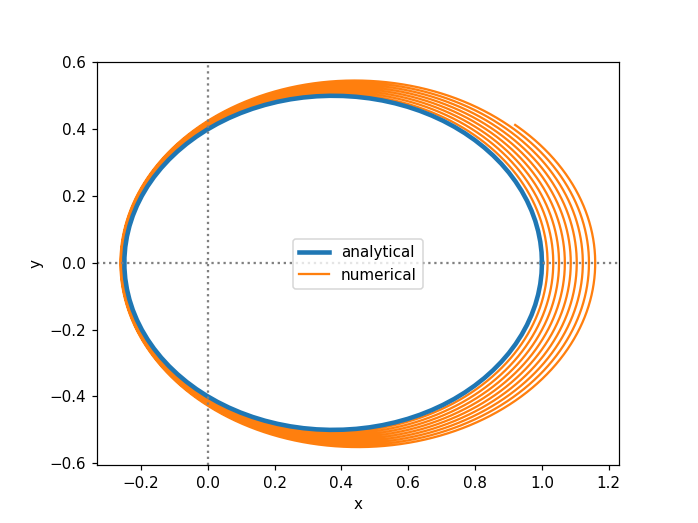

In [12]:
 # Plot the result on top of the analytical reference
fig = plt.figure()
plt.plot(xe, ye, lw=3, label="analytical", zorder=2)
ax = plt.gca()
ax.set_aspect("equal")
plt.axvline(x=0, ls=":", color="gray")
plt.axhline(y=0, ls=":", color="gray")
plt.plot(trajectory[:, 0], trajectory[:, 1], label="numerical", zorder=1)
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

<IPython.core.display.Javascript object>


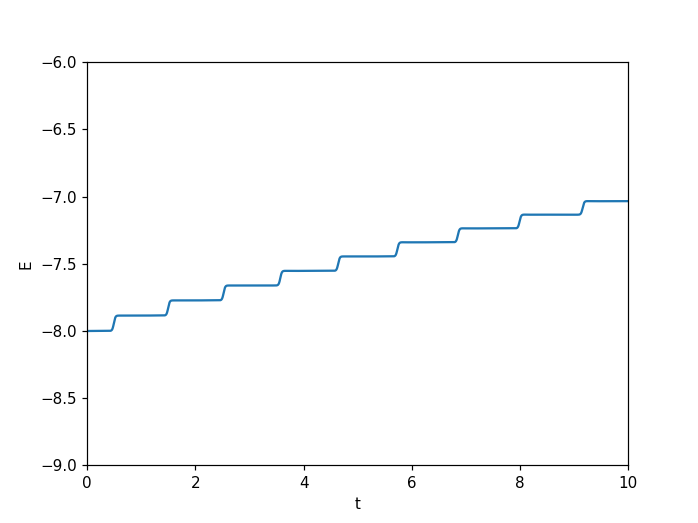

In [13]:
# Check the conservation of energy
fig = plt.figure()
plt.plot(dt * np.arange(E.size), E)
plt.xlim(0, dt * E.size)
plt.ylim(-9., -6.)
plt.xlabel("t")
plt.ylabel("E")
plt.show()

## Velocity Verlet integration

$$\begin{aligned}
      \mathbf{r}\left(t + \Delta t\right) &= \mathbf{r}\left(t\right) + \mathbf{v}\left(t\right)\Delta t + \frac{1}{2}\mathbf{a}\left(t\right)\left(\Delta t\right)^2\\
      \mathbf{v}\left(t + \Delta t\right) &= \mathbf{v}\left(t\right) + \frac{\mathbf{a}\left(t\right)+ \mathbf{a}\left(t + \Delta t\right)}{2}\Delta t
\end{aligned}$$

In [14]:
# Repeat  the processs with the new integrator
def calc_trajectory_verlet(dt, nsteps=100000):
    """Implementation of the velocity Verlet integration scheme. Return the trajectory and the energy."""
    trajectory = np.empty((nsteps, 2))
    E = np.empty(nsteps)
    pos = np.array([x0, 0.])
    trajectory[0, :] = pos
    v = np.array([0., v0])
    E[0] = calc_E(pos[0], pos[1], v[0], v[1])
    # We keep the forces at two time steps
    f = calc_f(*pos.tolist())
    for i in range(1, nsteps):
        pos += dt * (v + .5 * f * dt)
        newf = calc_f(*pos.tolist())
        v += .5 * (f + newf) * dt
        trajectory[i, :] = pos 
        E[i] = calc_E(pos[0], pos[1], v[0], v[1])
        f = newf
    return (np.array(trajectory), E)


# Call the integrator
trajectory, E = calc_trajectory_verlet(dt)

<IPython.core.display.Javascript object>


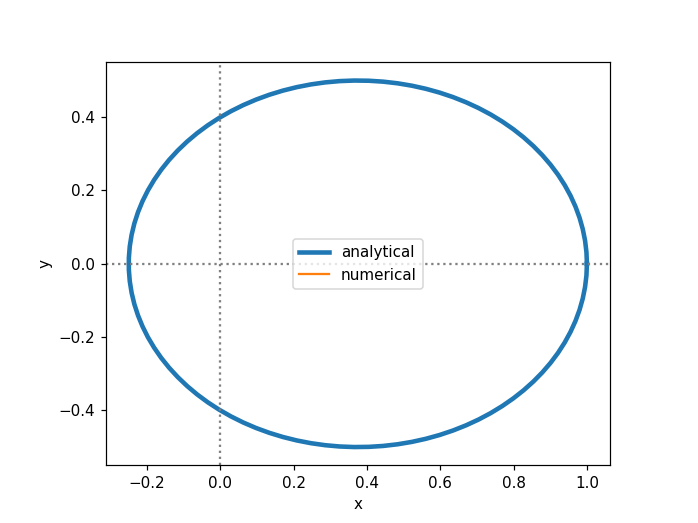

In [15]:
 # Plot the result on top of the analytical reference
fig = plt.figure()
plt.plot(xe, ye, lw=3, label="analytical", zorder=2)
ax = plt.gca()
ax.set_aspect("equal")
plt.axvline(x=0, ls=":", color="gray")
plt.axhline(y=0, ls=":", color="gray")
plt.plot(trajectory[:, 0], trajectory[:, 1], label="numerical", zorder=1)
plt.legend(loc="best")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

<IPython.core.display.Javascript object>


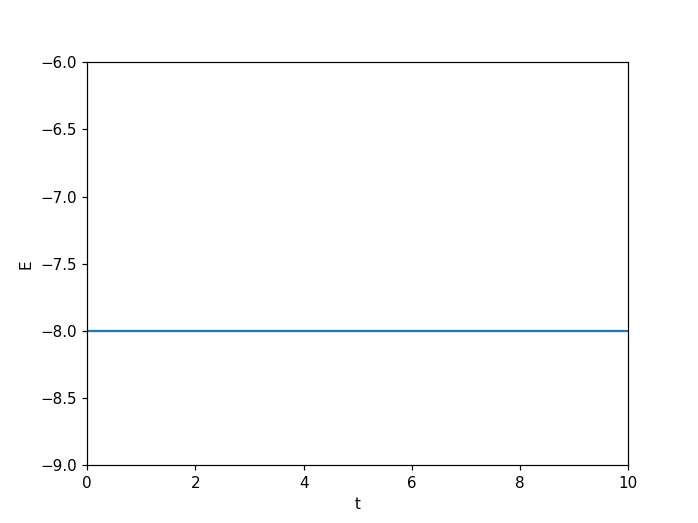

In [16]:
# Check the conservation of energy
fig = plt.figure()
plt.plot(dt * np.arange(E.size), E)
plt.xlim(0, dt * E.size)
plt.ylim(-9., -6.)
plt.xlabel("t")
plt.ylabel("E")
plt.show()